In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2021-07-01/"
s3_output_prefix = "{}_summary/".format(s3_prefix.rstrip("/"))
s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
iptmnet_data="https://research.bioinformatics.udel.edu/iptmnet_data/files/current/ptm.txt"

In [3]:
label_order = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination", "deubiquitination",  "other"]
pos_labels = list( filter(lambda x: x != 'other', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"other" : "Negative class"}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
is_download_files= False
is_create_groundtruth_labelling = False

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [9]:
!ls -l $local_temp_pred_dir | wc -l

     952


In [10]:
threshold_config = {'acetylation': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.20221626758575403,
  ('confidence_std', 'std'): 0.010931891264366925,
  ('confidence_std', 'min'): 0.186287313699722,
  ('confidence_std', '25%'): 0.19900196790695102,
  ('confidence_std', '50%'): 0.20083150267601002,
  ('confidence_std', '75%'): 0.21166041493415802,
  ('confidence_std', 'max'): 0.21330013871192902,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5777932286262508,
  ('confidence', 'std'): 0.017217069729986746,
  ('confidence', 'min'): 0.555882334709167,
  ('confidence', '25%'): 0.572159707546234,
  ('confidence', '50%'): 0.57360166311264,
  ('confidence', '75%'): 0.5849224925041191,
  ('confidence', 'max'): 0.602399945259094},
 'dephosphorylation': {('confidence_std', 'count'): 29.0,
  ('confidence_std', 'mean'): 0.21133935400124204,
  ('confidence_std', 'std'): 0.07727310272430898,
  ('confidence_std', 'min'): 0.11373741179704601,
  ('confidence_std', '25%'): 0.141093701124191,
  ('confidence_std', '50%'): 0.18553803861141202,
  ('confidence_std', '75%'): 0.255215793848037,
  ('confidence_std', 'max'): 0.41554290056228604,
  ('confidence', 'count'): 29.0,
  ('confidence', 'mean'): 0.8063360175182077,
  ('confidence', 'std'): 0.13017405501056736,
  ('confidence', 'min'): 0.32787588238716103,
  ('confidence', '25%'): 0.7709274291992181,
  ('confidence', '50%'): 0.8457427024841301,
  ('confidence', '75%'): 0.8899683952331541,
  ('confidence', 'max'): 0.914224922657012},
 'deubiquitination': {('confidence_std', 'count'): 2.0,
  ('confidence_std', 'mean'): 0.1863851696252815,
  ('confidence_std', 'std'): 0.002637275825296506,
  ('confidence_std', 'min'): 0.184520334005355,
  ('confidence_std', '25%'): 0.18545275181531826,
  ('confidence_std', '50%'): 0.1863851696252815,
  ('confidence_std', '75%'): 0.18731758743524476,
  ('confidence_std', 'max'): 0.18825000524520802,
  ('confidence', 'count'): 2.0,
  ('confidence', 'mean'): 0.4542059451341625,
  ('confidence', 'std'): 0.010661192844799884,
  ('confidence', 'min'): 0.446667343378067,
  ('confidence', '25%'): 0.45043664425611474,
  ('confidence', '50%'): 0.4542059451341625,
  ('confidence', '75%'): 0.4579752460122103,
  ('confidence', 'max'): 0.461744546890258},
 'methylation': {('confidence_std', 'count'): 9.0,
  ('confidence_std', 'mean'): 0.20187029076947058,
  ('confidence_std', 'std'): 0.011129410572280824,
  ('confidence_std', 'min'): 0.185736715793609,
  ('confidence_std', '25%'): 0.19583970308303802,
  ('confidence_std', '50%'): 0.19923907518386802,
  ('confidence_std', '75%'): 0.210324048995971,
  ('confidence_std', 'max'): 0.21908366680145203,
  ('confidence', 'count'): 9.0,
  ('confidence', 'mean'): 0.7966000636418656,
  ('confidence', 'std'): 0.01647822043812186,
  ('confidence', 'min'): 0.7693868875503541,
  ('confidence', '25%'): 0.780769705772399,
  ('confidence', '50%'): 0.798503041267395,
  ('confidence', '75%'): 0.809625148773193,
  ('confidence', 'max'): 0.8169981241226191},
 'other': {('confidence_std', 'count'): 1116.0,
  ('confidence_std', 'mean'): 0.015799599189941234,
  ('confidence_std', 'std'): 0.0407698558038574,
  ('confidence_std', 'min'): 0.0008510624757030001,
  ('confidence_std', '25%'): 0.00117629769374575,
  ('confidence_std', '50%'): 0.0021780409151680004,
  ('confidence_std', '75%'): 0.007007123087532501,
  ('confidence_std', 'max'): 0.303181886672973,
  ('confidence', 'count'): 1116.0,
  ('confidence', 'mean'): 0.9903799230800303,
  ('confidence', 'std'): 0.026711376001797505,
  ('confidence', 'min'): 0.5133088827133171,
  ('confidence', '25%'): 0.9944566637277598,
  ('confidence', '50%'): 0.9974353015422815,
  ('confidence', '75%'): 0.998221039772033,
  ('confidence', 'max'): 0.9985265731811521},
 'phosphorylation': {('confidence_std', 'count'): 139.0,
  ('confidence_std', 'mean'): 0.09348429794416534,
  ('confidence_std', 'std'): 0.11442879568269237,
  ('confidence_std', 'min'): 0.006378921680152001,
  ('confidence_std', '25%'): 0.013172945939004001,
  ('confidence_std', '50%'): 0.034169171005487005,
  ('confidence_std', '75%'): 0.13673919439315751,
  ('confidence_std', 'max'): 0.469867438077926,
  ('confidence', 'count'): 139.0,
  ('confidence', 'mean'): 0.9306538756802781,
  ('confidence', 'std'): 0.09291076266425286,
  ('confidence', 'min'): 0.548133730888366,
  ('confidence', '25%'): 0.9297615289688106,
  ('confidence', '50%'): 0.9758448600769041,
  ('confidence', '75%'): 0.98560282588005,
  ('confidence', 'max'): 0.990909934043884},
 'ubiquitination': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.1845212131738658,
  ('confidence_std', 'std'): 0.010037806334405529,
  ('confidence_std', 'min'): 0.174075484275817,
  ('confidence_std', '25%'): 0.177953422069549,
  ('confidence_std', '50%'): 0.18058878183364802,
  ('confidence_std', '75%'): 0.19217012822628002,
  ('confidence_std', 'max'): 0.197818249464035,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5571501374244686,
  ('confidence', 'std'): 0.07332355556921501,
  ('confidence', 'min'): 0.42922157049179005,
  ('confidence', '25%'): 0.5765218138694761,
  ('confidence', '50%'): 0.579930007457733,
  ('confidence', '75%'): 0.58320677280426,
  ('confidence', 'max'): 0.616870522499084}}

In [11]:
def get_summary_df(local_temp_pred_dir, use_std=True, conf_percentile="50%", confidence_std_percentile="50%"):
    list_df_high_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "pubmedId", "participant1Id", "participant2Id", "participant1Name", "participant2Name"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        for k,t in threshold_config.items():
            conf_median = t[('confidence', conf_percentile)]
            conf_std_median = t[('confidence_std', confidence_std_percentile)]
            
            # HQ filter query
            qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
           
            high_quality_frames_per_interaction.append(df.query(qry))

        high_quality_df = pd.concat(high_quality_frames_per_interaction)

        list_df_high_quality.append(high_quality_df)

    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary)



In [12]:
def get_partipants_key_raw(participants):
    """
    Example input
    [{'uniprotid': 'P19388',
  'alias': [['rpab1_human'],
   ['DNA-directed RNA polymerases I, II, and III subunit RPABC1'],
   ['POLR2E'],
   ['DNA-directed RNA polymerase II subunit E'],
   ['RPB5 homolog'],
   ['DNA-directed RNA polymerase II 23 kDa polypeptide'],
   ['XAP4']],
  'alternative_uniprots': ['Q6PIH5', 'Q9BT06', 'O43380', 'B2R6L4', 'D6W5Y1']},
 {'uniprotid': 'Q96SB4',
  'alias': [['srpk1_human'],
   ['SRSF protein kinase 1'],
   ['Serine/arginine-rich protein-specific kinase 1'],
   ['SFRS protein kinase 1'],
   ['SRPK1']],
  'alternative_uniprots': ['Q5R365', 'Q5R364', 'B4DS61', 'Q8IY12', 'Q12890']}]
    """
    participant_uniprot = []
    for p in participants:
        
        participant_uniprot.append(str(p["uniprotid"]))
        
        
    result = frozenset( list(filter (lambda x: x is not None, participant_uniprot)))
    
    return result


def is_ptm_ppi_in_training(df, training_df):
    training_participants_pred = pd.DataFrame()
    training_participants_pred["pubmedId"] = training_df["pubmedId"]
    training_participants_pred["participants"] = training_df["participants"].apply(get_partipants_key_raw)
    training_participants_pred["prediction"] = training_df["interactionType"]
    training_participants_pred["ptm-ppi"] = training_participants_pred[["prediction", "participants"]].apply(tuple, axis=1)
    training_participants_pred["ptm-ppi-pubmed"] = training_participants_pred[["prediction","participants","pubmedId" ]].apply(tuple, axis=1)


    df_particpiants_pred = pd.DataFrame()
    df_particpiants_pred["pubmedId"] = df["pubmedId"]
    df_particpiants_pred["participants"] = df[["participant2Id", "participant1Id"]].apply(frozenset, axis=1)
    df_particpiants_pred["prediction"] = df["prediction"]
    df_particpiants_pred["ptm-ppi"] = df_particpiants_pred[["prediction","participants" ]].apply(tuple, axis=1)
    df_particpiants_pred["ptm-ppi-pubmed"] = df_particpiants_pred[["prediction","participants","pubmedId" ]].apply(tuple, axis=1)
 
    result = pd.DataFrame()
    result["is_in_train_ptmppi"] =  df_particpiants_pred["ptm-ppi"].isin(training_participants_pred["ptm-ppi"])
    result["is_in_train_record"]=  df_particpiants_pred["ptm-ppi-pubmed"].isin(training_participants_pred["ptm-ppi-pubmed"])
    
    
    return result


def is_in_training_pubmed(df, training_df):
    return df["pubmedId"].isin(training_df["pubmedId"])

In [13]:
download_file(s3_data, local_temp_wk_dir)
data_file = os.path.join(local_temp_wk_dir, s3_data.split("/")[-1])
data_training_full_df = pd.read_json(data_file)

In [14]:
%%time 


df_high_quality_threshold, df_summary = get_summary_df (local_temp_pred_dir, use_std=True)
df_high_quality_threshold[["PTMPPIInTrainingData", "RecordInTrainingData"]] = is_ptm_ppi_in_training( df_high_quality_threshold, data_training_full_df)
df_summary[["PTMPPIInTrainingData", "RecordInTrainingData"]] = is_ptm_ppi_in_training( df_summary, data_training_full_df)

CPU times: user 2min 57s, sys: 6.99 s, total: 3min 4s
Wall time: 3min 5s


In [15]:
num_papers_threshold=2

In [16]:
df_high_quality = df_high_quality_threshold.groupby(["prediction", "participant1Id", "participant2Id"])\
                    .filter(lambda x: len(x) >= num_papers_threshold)

In [17]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


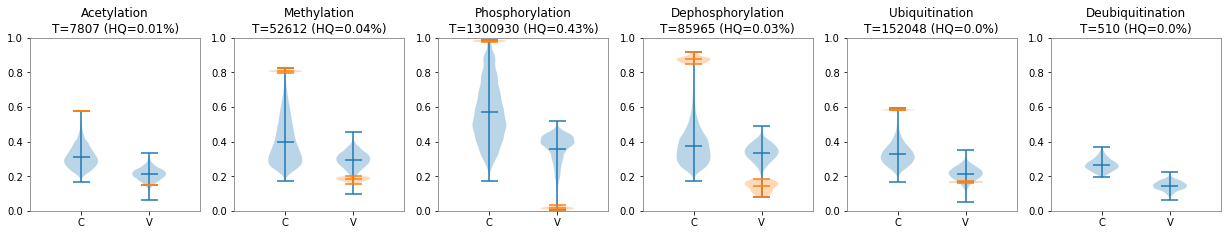

In [18]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [19]:
df_summary.shape

(1600103, 10)

In [20]:
df_summary.groupby("prediction").describe().T

prediction             acetylation  dephosphorylation  deubiquitination  \
confidence     count  7.814000e+03       8.599600e+04      5.120000e+02   
               mean   3.127081e-01       3.770867e-01      2.661245e-01   
               std    6.387505e-02       1.049603e-01      3.535714e-02   
               min    1.679264e-01       1.721430e-01      1.925499e-01   
               25%    2.649182e-01       2.990283e-01      2.418651e-01   
               50%    3.041625e-01       3.621136e-01      2.620904e-01   
               75%    3.534613e-01       4.338882e-01      2.849126e-01   
               max    6.006500e-01       9.174241e-01      4.617445e-01   
confidence_std count  7.814000e+03       8.599600e+04      5.120000e+02   
               mean   2.105105e-01       3.360322e-01      1.450459e-01   
               std    3.650847e-02       5.060654e-02      2.551565e-02   
               min    6.070806e-02       8.261938e-02      6.051787e-02   
               25%    1.862821e-01       3.025211e-01      1.279653e-01   
               50%    2.113768e-01       3.384592e-01      1.461324e-01   
               75%    2.349800e-01       3.727958e-01      1.622773e-01   
               max    3.348950e-01       4.914492e-01      2.244747e-01   
pubmedId       count  7.814000e+03       8.599600e+04      5.120000e+02   
               mean   1.827663e+07       1.606554e+07      2.032314e+07   
               std    7.745668e+06       8.035124e+06      6.941911e+06   
               min    1.140000e+03       4.500000e+02      7.305440e+05   
               25%    1.193176e+07       9.572470e+06      1.642670e+07   
               50%    1.934024e+07       1.642783e+07      2.158914e+07   
               75%    2.474807e+07       2.285067e+07      2.592945e+07   
               max    3.052525e+07       3.052454e+07      3.047828e+07   

prediction             methylation  phosphorylation  ubiquitination  
confidence     count  5.262200e+04     1.301106e+06    1.520530e+05  
               mean   3.968556e-01     5.697892e-01    3.257748e-01  
               std    1.271545e-01     1.720569e-01    5.966913e-02  
               min    1.719247e-01     1.720937e-01    1.636227e-01  
               25%    2.950942e-01     4.383482e-01    2.821410e-01  
               50%    3.685337e-01     5.513105e-01    3.204003e-01  
               75%    4.801754e-01     6.917892e-01    3.631499e-01  
               max    8.269717e-01     9.907943e-01    6.149684e-01  
confidence_std count  5.262200e+04     1.301106e+06    1.520530e+05  
               mean   2.942120e-01     3.583199e-01    2.139932e-01  
               std    4.816604e-02     8.640525e-02    3.875029e-02  
               min    9.499982e-02     6.206166e-03    5.022085e-02  
               25%    2.619969e-01     3.160160e-01    1.879721e-01  
               50%    2.956794e-01     3.818166e-01    2.151539e-01  
               75%    3.279718e-01     4.198187e-01    2.412301e-01  
               max    4.528537e-01     5.203627e-01    3.500032e-01  
pubmedId       count  5.262200e+04     1.301106e+06    1.520530e+05  
               mean   1.699505e+07     1.709475e+07    1.856129e+07  
               std    8.248884e+06     7.860495e+06    7.368797e+06  
               min    5.600000e+01     6.000000e+01    1.755000e+03  
               25%    1.037267e+07     1.067120e+07    1.242423e+07  
               50%    1.791162e+07     1.753581e+07    1.943586e+07  
               75%    2.399712e+07     2.367649e+07    2.462559e+07  
               max    3.052509e+07     3.052527e+07    3.052516e+07

In [21]:
df_high_quality[~df_high_quality.PTMPPIInTrainingData].shape, df_high_quality.shape

((1502, 23), (1680, 23))

In [22]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold, df_high_quality_multiple_paper ):
    
    participants_cols = ["participant1Id", "participant2Id"]
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    df_full["participants"] = df_full[participants_cols].apply(frozenset, axis=1)
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()
    df_high_quality_threshold["participants"] = df_high_quality_threshold[participants_cols].apply(frozenset,
                                                                                                   axis=1)

        
    df_high_quality_multiple_paper = df_high_quality_multiple_paper[~df_high_quality_multiple_paper.RecordInTrainingData].copy()
    df_high_quality_multiple_paper["participants"] = df_high_quality_multiple_paper[participants_cols]\
                                                        .apply(frozenset, axis=1)
        
    
    summary_df = pd.DataFrame(df_full.query("prediction != 'other'")\
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    summary_unique_df = pd.DataFrame(df_full.query("prediction != 'other'")\
                          .groupby([ "prediction", "participants"])\
                          .size()\
                          .groupby(level=0).size())\
                          .rename(columns={0: "all_count_unique"})
    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    thresh_unique_df = pd.DataFrame(df_high_quality_threshold\
              .groupby([ "prediction", "participants"])\
              .size()\
              .groupby(level=0).size())\
              .rename(columns={0: "thresh_count_unique"})
            
    
    
    multi_paper_df = pd.DataFrame(df_high_quality_multiple_paper\
              .groupby('prediction').size())\
              .rename(columns={0: "multipaper_count"})
    
    multi_paper_unique_df = pd.DataFrame(df_high_quality_multiple_paper\
              .groupby([ "prediction", "participants"])\
             .size()\
              .groupby(level=0).size())\
              .rename(columns={0: "multipaper_count_unique"})
    
    
    dfs = [summary_df, summary_unique_df, thresh_df, thresh_unique_df, multi_paper_df, multi_paper_unique_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold, df_high_quality )

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrrrrrr}
\toprule
{} &  all\_count &  all\_count\_unique &  thresh\_count &  thresh\_count\_unique &  multipaper\_count &  multipaper\_count\_unique \\
prediction        &            &                   &               &                      &                   &                          \\
\midrule
acetylation       &       7807 &              6113 &             1 &                    1 &                 0 &                        0 \\
dephosphorylation &      85965 &             50004 &            29 &                   29 &                 1 &                        1 \\
deubiquitination  &        510 &               460 &             0 &                    0 &                 0 &                        0 \\
methylation       &      52612 &             29914 &            20 &                   18 &                 4 &                        2 \\
phosphorylation   &    1300930 &            381157 &          5654 &                 4532 &              1659 &            

,all_count,all_count_unique,thresh_count,thresh_count_unique,multipaper_count,multipaper_count_unique
prediction,,,,,,
acetylation,7807,6113,1,1,0,0
dephosphorylation,85965,50004,29,29,1,1
deubiquitination,510,460,0,0,0,0
methylation,52612,29914,20,18,4,2
phosphorylation,1300930,381157,5654,4532,1659,537
ubiquitination,152048,78859,4,4,0,0
Total,1599872,546507,5708,4584,1664,540


In [23]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [24]:
df_high_quality.sample(n=10, random_state=45)

,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,PTMPPIInTrainingData,RecordInTrainingData
4909,7527397,P05556,beta 1 integrin,Q05397,p125FAK,Fibroblasts or their conditioned medium stimul...,Fibroblasts or their conditioned medium stimul...,"[{'start': '235', 'end': '240', 'name': 'c-Met...","{'4233': 'P08581', '7414': 'P18206', '5747': '...","[{'charOffset': 235, 'len': 6, 'text': 'P08581...",0.007232,0.978544,0.005047,0.002061,0.002875,0.002316,0.001925,phosphorylation,0.978544,0.030537,"[0.9963300824165341, 0.974558889865875, 0.9875...",False,False
1804,26283674,P42345,mTOR,P62753,ribosomal protein S6,Secondary hyperparathyroidism is characterized...,Secondary hyperparathyroidism is characterized...,"[{'start': '66', 'end': '85', 'name': 'parathy...","{'5741': 'P01270', '2475': 'P42345', '6194': '...","[{'charOffset': 66, 'len': 6, 'text': 'P01270'...",0.002440,0.989444,0.001717,0.001887,0.001563,0.001454,0.001494,phosphorylation,0.989444,0.007363,"[0.9821953177452081, 0.977951169013977, 0.9942...",False,False
1509,11520496,P07949,Ret,P39905,glial cell line-derived neurotrophic factor,Ret oncoprotein is a functional receptor for t...,P07949 oncoprotein is a functional receptor fo...,"[{'start': '0', 'end': '3', 'name': 'Ret', 'ty...","{'5979': 'P07949', '2668': 'P39905'}","[{'charOffset': 0, 'len': 6, 'text': 'P07949'}...",0.004491,0.983960,0.004539,0.001943,0.001820,0.001785,0.001463,phosphorylation,0.983960,0.012618,"[0.9947407841682431, 0.9723135828971861, 0.991...",False,False
131,9848178,Q15746,myosin light chain kinase,Q7Z406,myosin,Phosphorylation of myosin regulatory light cha...,Phosphorylation of Q7Z406 regulatory light cha...,"[{'start': '19', 'end': '25', 'name': 'myosin'...","{'79784': 'Q7Z406', '4638': 'Q15746'}","[{'charOffset': 19, 'len': 6, 'text': 'Q7Z406'...",0.008135,0.979634,0.002655,0.002609,0.002779,0.001944,0.002244,phosphorylation,0.979634,0.030478,"[0.9942805767059321, 0.9643478989601131, 0.994...",False,False
1819,27144724,P35968,vascular endothelial growth factor receptor,P42345,mammalian target of rapamycin,Despite a variety of therapies for advanced ad...,Despite a variety of therapies for advanced ad...,"[{'start': '90', 'end': '133', 'name': 'vascul...","{'3791': 'P35968', '2475': 'P42345'}","[{'charOffset': 90, 'len': 6, 'text': 'P35968'...",0.004138,0.978148,0.004409,0.005588,0.003102,0.002548,0.002065,phosphorylation,0.978148,0.020899,"[0.97765439748764, 0.9928927421569821, 0.99305...",False,False
814,28223426,P12931,Src,Q05397,FAK,Trastuzumab in combination with chemotherapy i...,Trastuzumab in combination with chemotherapy i...,"[{'start': '73', 'end': '81', 'name': 'patient...","{'2064': 'P04626', '6714': 'P12931', '5747': '...","[{'charOffset': 93, 'len': 6, 'text': 'P04626'...",0.004614,0.986170,0.001929,0.002020,0.001991,0.001469,0.001807,phosphorylation,0.986170,0.009145,"[0.978983461856842, 0.9773170351982111, 0.9823...",False,False
679,22463874,O14733,MEK,P28482,extracellular signal-regulated kinase,The mitogen-activated protein kinase (MAPK) si...,The mitogen-activated protein kinase (MAPK) si...,"[{'start': '238', 'end': '275', 'name': 'extra...","{'5594': 'P28482', '5609': 'O14733', '5037': '...","[{'charOffset': 238, 'len': 6, 'text': 'P28482...",0.003703,0.985636,0.001731,0.003442,0.001740,0.001983,0.001766,phosphorylation,0.985636,0.010561,"[0.9911217689514161, 0.9924314022064201, 0.996...",False,False
1428,20430051,P35228,inducible nitric oxide synthase,P40763,STAT3,Treatment with the bacterial endotoxin lipopol...,Treatment with the bacterial endotoxin lipopol...,"[{'start': '149', 'end': '180', 'name': 'induc...","{'4843': 'P35228', '6774': 'P40763'}","[{'charOffset': 149, 'len': 6, 'text': 'P35228...",0.00372

In [25]:
df_high_quality["unique_gene_count"] = df_high_quality["gene_to_uniprot_map"].apply(lambda x: len(x))

In [26]:
df_high_quality.groupby("prediction")[["confidence","unique_gene_count"]].describe()

confidence                                          \
                       count      mean       std       min       25%   
prediction                                                             
dephosphorylation        4.0  0.892749  0.017481  0.872069  0.883297   
methylation              4.0  0.805350  0.008237  0.799076  0.800123   
phosphorylation       1672.0  0.982143  0.003594  0.975851  0.979168   

                                                unique_gene_count            \
                        50%       75%       max             count      mean   
prediction                                                                    
dephosphorylation  0.892811  0.902263  0.913303               4.0  3.250000   
methylation        0.802572  0.807799  0.817178               4.0  2.250000   
phosphorylation    0.982003  0.985159  0.990151            1672.0  2.928828   

                                                        
                        std  min   25%  50%   75%  max  
prediction                                              
dephosphorylation  0.957427  2.0  2.75  3.5  4.00  4.0  
methylation        0.500000  2.0  2.00  2.0  2.25  3.0  
phosphorylation    1.166183  2.0  2.00  3.0  4.00  8.0

In [27]:
predictions_above_threshold_file = "predictions_above_threshold.json"
df_high_quality_threshold.to_json(predictions_above_threshold_file, orient='records')

In [28]:
upload_file(predictions_above_threshold_file, "{}/".format(s3_output_prefix.rstrip("/")))

In [29]:
predictions_highquality_file = "predictions_above_threshold_hq.json"
df_high_quality.to_json(predictions_highquality_file, orient='records')
upload_file(predictions_highquality_file, "{}/".format(s3_output_prefix.rstrip("/")))

In [30]:
samples_per_interaction = 30

samples_subset = df_high_quality.query("RecordInTrainingData  == False")\
                .groupby('prediction', group_keys=False)\
                .apply(lambda x: x.sample(min(len(x), samples_per_interaction),random_state=45))

samples_subset.groupby(["prediction"])["prediction"].count()

prediction
dephosphorylation     1
methylation           4
phosphorylation      30
Name: prediction, dtype: int64

In [31]:
samples_subset.sample(n=5)

,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,PTMPPIInTrainingData,RecordInTrainingData,unique_gene_count
2736,16177125,P01579,IFN-gamma,P42224,STAT-1,Although many patients with disseminated nontu...,Although many patients with disseminated nontu...,"[{'start': '14', 'end': '22', 'name': 'patient...","{'3458': 'P01579', '6772': 'P42224', '7124': '...","[{'charOffset': 108, 'len': 6, 'text': 'P01579...",0.007289,0.981569,0.001937,0.002352,0.002641,0.002012,0.002200,phosphorylation,0.981569,0.022893,"[0.9215018153190611, 0.970322430133819, 0.9948...",False,False,4
714,25472611,P01308,Insulin,P35568,insulin receptor substrate-1,Insulin resistance in metabolic syndrome subje...,P01308 resistance in metabolic syndrome subjec...,"[{'start': '0', 'end': '7', 'name': 'Insulin',...","{'3630': 'P01308', '6517': 'P14672', '3667': '...","[{'charOffset': 0, 'len': 6, 'text': 'P01308'}...",0.004152,0.982600,0.005004,0.002439,0.002115,0.002150,0.001539,phosphorylation,0.982600,0.018758,"[0.9614178538322441, 0.990189135074615, 0.9937...",False,False,4
1698,2565604,P00533,EGFr,P04626,neu,The neu gene was first identified in rat tumor...,The P04626 gene was first identified in rat tu...,"[{'start': '4', 'end': '7', 'name': 'neu', 'ty...","{'2064': 'P04626', '1956': 'P00533'}","[{'charOffset': 4, 'len': 6, 'text': 'P04626'}...",0.003105,0.977964,0.001753,0.006103,0.004496,0.002945,0.003635,phosphorylation,0.977964,0.025563,"[0.9838946461677551, 0.917335748672485, 0.9891...",False,False,2
1661,7689149,P12931,c-Src,P41240,C-terminal Src kinase,The kinase activity of c-Src is normally repre...,The kinase activity of P12931 is normally repr...,"[{'start': '23', 'end': '28', 'name': 'c-Src',...","{'6714': 'P12931', '1445': 'P41240'}","[{'charOffset': 23, 'len': 6, 'text': 'P12931'...",0.003955,0.983984,0.002979,0.003150,0.002061,0.001757,0.002114,phosphorylation,0.983984,0.013801,"[0.9815626144409181, 0.9526808261871331, 0.991...",False,False,2
1451,11270616,P19838,NF-kappaB,P25963,IkappaB alpha,This review will discuss the recent literature...,This review will discuss the recent literature...,"[{'start': '77', 'end': '86', 'name': 'NF-kapp...","{'4790': 'P19838', '4792': 'P25963', '5970': '...","[{'charOffset': 77, 'len': 6, 'text': 'P19838'...",0.013157,0.976810,0.003106,0.001673,0.001842,0.002067,0.001346,phosphorylation,0.976810,0.019138,"[0.9690867662429811, 0.973223686218261, 0.9954...",False,False,5


## Comparison with iPTMNet

In [32]:
import urllib.request
from io import StringIO
import pandas as pd


def get_iptmnet_df(url):
    
    with urllib.request.urlopen(url) as f:
        data = f.read().decode('utf-8')

    df = pd.read_csv(StringIO(data), sep="\t", dtype=str)
    df.columns = ["ptm_type","source","substrate_UniProtAC",
                  "substrate_genename", "organism","site",
                  "enzyme_UniProtAC","enzyme_genename","note","pubmedId"]
    
    df["participants"] = df[["substrate_UniProtAC","enzyme_UniProtAC"]].apply(lambda r: frozenset(r) , axis=1)
    
    # Filter only those that have enzyme substrate
    df = df[~df[["ptm_type", "substrate_UniProtAC","enzyme_UniProtAC"]].isna().any(axis=1)]
    
    return df


def is_match(prediction, participants, df_reference ):
    df_match = df_reference.query(f"prediction == {prediction} and participants == {participants}  ")
    
    return len(df_match) > 0


def remove_isoform(x):
    x = str(x)
    if "-" in x:
        l = x.index("-")
        x= x[:l]
    return x


def is_uniprot(x):
    x = str(x)
    
    # Starting with PR is a different Id
    r = not x.startswith("PR:")
    
    return r


def is_self_relation(x,y):
    return x == y 
  

def is_uniprot_participants(items):
    return all([is_uniprot(x) for x in items])
   
def is_ptm_ppi_in_predictions(df, df_reference, ref_ptm_col = "prediction"):


    df_reference = df_reference[[ref_ptm_col, "participant1Id","participant2Id", "PTMPPIInTrainingData"]].copy(deep =True)
    df = df[["ptm_type" ,"substrate_UniProtAC" , "enzyme_UniProtAC"]].copy(deep =True)

    df_reference["participants"] =  df_reference[["participant1Id","participant2Id"]].apply(frozenset , axis=1)
    df_reference["triplet"] =  df_reference[[ref_ptm_col,"participants"]].apply(frozenset , axis=1)
    
    # Clean up
    df["ptm_type"] = df["ptm_type"].str.lower()
    df["substrate_UniProtAC"] = df["substrate_UniProtAC"].apply(remove_isoform)
    df["enzyme_UniProtAC"] = df["enzyme_UniProtAC"].apply(remove_isoform)
    
    df["participants"] = df[["substrate_UniProtAC","enzyme_UniProtAC"]].apply(frozenset , axis=1) 
    df["triplet"] = df[["ptm_type", "participants"]].apply(frozenset, axis=1)
    
    result = pd.DataFrame()
    result["is_pred_in_iptmnet"] = df["triplet"].isin(df_reference.query("PTMPPIInTrainingData == False")["triplet"])
    result["is_training_in_iptmnet"]= df["triplet"].isin(df_reference.query("PTMPPIInTrainingData == True")["triplet"])
    
    
    return result
        
def prepare_iptmnet_summary(df) :
    participant_cols = [ "enzyme_UniProtAC","substrate_UniProtAC" ]
    df["is_uniprot_participants"] = df[participant_cols].apply(is_uniprot_participants,1)
    df["is_self_relation"] = df[participant_cols].apply(lambda x: is_self_relation(*x),1)
    
    df_itptmnet_dedup = df.drop_duplicates(subset=["ptm_type", "participants"])

    # Summary
    df_itptmnet_summary = df_itptmnet.groupby("ptm_type").size().to_frame()
    df_itptmnet_summary.columns = [ "Total"]
    df_itptmnet_summary = df_itptmnet_summary.reset_index()
    
    # De duped
    df_itptmnet_summary["deduped"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}'"))) 
    
    df_itptmnet_summary["is_uniprot_participants"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}' and is_uniprot_participants ==True")))
    
    df_itptmnet_summary["is_predicted"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}' and is_predicted==True")))
    
  
    df_itptmnet_summary["is_predicted_in_Training"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}' and is_predicted_inTraining==True")))
   


    
    df_itptmnet_summary["is_in_hq_threshold"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}' and is_hq_threshold==True")))
    
    
    df_itptmnet_summary["is_hq_in_Training"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}' and is_hq_isinTraining==True")))
   

    df_itptmnet_summary["is_rlims"] = df_itptmnet_summary["ptm_type"]\
                                    .apply(lambda x: len(df_itptmnet_dedup.query(f"ptm_type == '{x}' and source.str.contains('rlim') ")))
     
    
    df_itptmnet_summary["ptm_type"] = df_itptmnet_summary["ptm_type"].str.lower()
    return df_itptmnet_summary
    

In [33]:
df_itptmnet = get_iptmnet_df(iptmnet_data)

In [34]:
df_itptmnet[["is_hq_threshold", "is_hq_isinTraining" ]] = is_ptm_ppi_in_predictions(df_itptmnet, df_high_quality_threshold)

df_itptmnet[["is_predicted", "is_predicted_inTraining"]] = is_ptm_ppi_in_predictions(df_itptmnet, df_summary)



In [35]:
df_itptmnet_summary  = prepare_iptmnet_summary(df_itptmnet)
df_itptmnet_summary

,ptm_type,Total,deduped,is_uniprot_participants,is_predicted,is_predicted_in_Training,is_in_hq_threshold,is_hq_in_Training,is_rlims
0,acetylation,141,73,12,0,0,0,0,0
1,methylation,7,4,4,0,0,0,0,0
2,o-glycosylation,2,1,1,0,0,0,0,1
3,phosphorylation,21050,8949,8805,3270,292,815,155,358
4,sumoylation,1,1,0,0,0,0,0,0
5,ubiquitination,2,1,0,0,0,0,0,0


In [36]:
df_summary.query("pubmedId == '9360956'")

,prediction,confidence,confidence_std,pubmedId,participant1Id,participant2Id,participant1Name,participant2Name,PTMPPIInTrainingData,RecordInTrainingData
101,phosphorylation,0.979037,0.022575,9360956,P04049,P63104,c-Raf,14-3-3 zeta,False,False
102,phosphorylation,0.980128,0.021879,9360956,P63104,Q9Y6X8,14-3-3 zeta,Raf,False,False


In [37]:
df_itptmnet.query("is_predicted == False and is_uniprot_participants == True and is_self_relation==False")\
    .sample(n=10)

,ptm_type,source,substrate_UniProtAC,substrate_genename,organism,site,enzyme_UniProtAC,enzyme_genename,note,pubmedId,participants,is_hq_threshold,is_hq_isinTraining,is_predicted,is_predicted_inTraining,is_uniprot_participants,is_self_relation
243884,PHOSPHORYLATION,sign,P24928,POLR2A,Homo sapiens (Human),S1619,P28482,MAPK1,NaN,14662762,"(P28482, P24928)",False,False,False,False,True,False
118492,PHOSPHORYLATION,pelm,P53566,Cebpa,Mus musculus (Mouse),S193,Q64261,Cdk6,LTP,16537903,"(P53566, Q64261)",False,False,False,False,True,False
160639,PHOSPHORYLATION,pgrd,Q07657,SHS1,Saccharomyces cerevisiae (strain ATCC 204508 /...,S522,P17157,PHO85,NaN,"17330950,18407956,18431499,19684113,19779198,2...","(P17157, Q07657)",False,False,False,False,True,False
110901,PHOSPHORYLATION,pelm,P08955,CAD,Mesocricetus auratus (Golden hamster),T456,A0A1U7QEZ9,Mapk1,LTP,"10659854,11872754","(A0A1U7QEZ9, P08955)",False,False,False,False,True,False
23994,PHOSPHORYLATION,hprd,O43521-1,BCL2L11,Homo sapiens (Human),S69,P53779,MAPK10,in vitro;in vivo,12818176,"(O43521-1, P53779)",False,False,False,False,True,False
156051,PHOSPHORYLATION,pgrd,P53135,SLD3,Saccharomyces cerevisiae (strain ATCC 204508 /...,S459,YPL153C,RAD53,NaN,20835227,"(YPL153C, P53135)",False,False,False,False,True,False
87338,PHOSPHORYLATION,npro,P41162,ETV3,Homo sapiens (Human),S139,P28482,MAPK1,NaN,22028470,"(P28482, P41162)",False,False,False,False,True,False
145084,PHOSPHORYLATION,pgrd,P16140,VMA2,Saccharomyces cerevisiae (strain ATCC 204508 /...,S511,P38111,MEC1,NaN,"17330950,17563356,18407956,19684113,19779198,1...","(P38111, P16140)",False,False,False,False,True,False
148351,PHOSPHORYLATION,pgrd,P32598,GLC7,Saccharomyces cerevisiae (strain ATCC 204508 /...,S3,P38111,MEC1,NaN,"20190278,20489023","(P32598, P38111)",False,False,False,False,True,False
29040,PHOSPHORYLATION,hprd,P02686-6,MBP,Homo sapiens (Human),T36,P17612,PRKACA,in vitro,2413024,"(P02686-6, P17612)",False,False,False,False,True,False


In [38]:
print(df_itptmnet_summary.to_latex(index=False, columns=["ptm_type","Total",
                                                         "deduped",
                                                         "is_uniprot_participants",
                                                         "is_predicted", 
                                                         "is_in_hq_threshold","is_rlims"]))

\begin{tabular}{lrrrrrr}
\toprule
        ptm\_type &  Total &  deduped &  is\_uniprot\_participants &  is\_predicted &  is\_in\_hq\_threshold &  is\_rlims \\
\midrule
     acetylation &    141 &       73 &                       12 &             0 &                   0 &         0 \\
     methylation &      7 &        4 &                        4 &             0 &                   0 &         0 \\
 o-glycosylation &      2 &        1 &                        1 &             0 &                   0 &         1 \\
 phosphorylation &  21050 &     8949 &                     8805 &          3270 &                 815 &       358 \\
     sumoylation &      1 &        1 &                        0 &             0 &                   0 &         0 \\
  ubiquitination &      2 &        1 &                        0 &             0 &                   0 &         0 \\
\bottomrule
\end{tabular}



### Create ground truth training jobs

In [39]:
import json
import json
def create_manifest_file(df, outfile):
    items = df.to_dict(orient='records' )
    with open(outfile , "w") as f:
        for item in items:
            # Write without new lines
            item_m  = {}
            item_m["source"] = json.dumps(item)
            f.write(json.dumps(item_m).replace("\n", "\t"))
            f.write("\n")

In [40]:
def create_manifest_per_interaction(samples_subset_df, s3_output_prefix):
    samples_subset_file = "predictions_sample_subset.json"
    samples_subset_df.to_json(samples_subset_file, orient='records')
    upload_file(samples_subset_file, "{}/".format(s3_output_prefix.rstrip("/")))


    manifest_file = "predictions_sample_subset.mainfest"
    create_manifest_file(samples_subset_df, manifest_file)
    upload_file(manifest_file, "{}/".format(s3_output_prefix.rstrip("/")))

    # Create one manifest file per interaction type
    m_files=[]
    for i in list(samples_subset_df["prediction"].unique()):
        manifest_file = "predictions_sample_subset_{}.mainfest".format(i)
        s3_manifest_file = "{}/{}".format(s3_output_prefix.rstrip("/"), manifest_file)
        create_manifest_file(samples_subset_df.query("prediction == '{}'".format(i)), manifest_file)
        upload_file(manifest_file, s3_manifest_file)
        
        m_files.append(s3_manifest_file)
    return m_files


In [41]:
s3_manifests = create_manifest_per_interaction(samples_subset, s3_output_prefix)

In [42]:
import boto3
import sagemaker

In [43]:
from datetime import datetime

def create_groundtruth_labelling_job(s3_manifest, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_name, label_attribute_name="prediction", workforce_type= "private-crowd" ):
    client = boto3.client('sagemaker')
    
    sagemaker_session = sagemaker.Session()
    account_id =  boto3.client('sts').get_caller_identity().get('Account')
    region = boto3.session.Session().region_name
    
    workforce_arn = "arn:aws:sagemaker:{}:{}:workteam/{}/{}".format(region, account_id, workforce_type, workforce_name)
    role_arn = "arn:aws:iam::{}:role/{}".format( account_id,  role)
    pre_lambda_arn = "arn:aws:lambda:{}:{}:function:{}".format(region, account_id,  pre_lambda)
    post_lambda_arn = "arn:aws:lambda:{}:{}:function:{}".format(region, account_id,  post_lambda)
    
    num_workers_per_object = 1
    task_time_limit_sec = 60  * 60 * 5
    task_availablity_sec =60  * 60 * 24 * 10
    
    job = client.create_labeling_job(LabelingJobName=job_name
                                    ,LabelAttributeName = label_attribute_name
                                    ,InputConfig = {
                                        "DataSource": {
                                            'S3DataSource': {
                                            'ManifestS3Uri': s3_manifest
                                            }
                                        }
                                        
                                    }
                                  ,OutputConfig={
                                        'S3OutputPath': s3_gt_output
                                    }

                                  , RoleArn = role_arn
                                  , HumanTaskConfig={
                                    'WorkteamArn': workforce_arn,
                                    'UiConfig': {
                                        'UiTemplateS3Uri': s3_template
                                    },
                                    'PreHumanTaskLambdaArn': pre_lambda_arn,
                                    'TaskKeywords': [
                                        'PPI',
                                    ],
                                    'TaskTitle': 'Verify PPI extraction for protein {}'.format(s3_manifest.split("/")[-1]),
                                    'TaskDescription': 'Verifies PPi extraction',
                                    'NumberOfHumanWorkersPerDataObject': num_workers_per_object,
                                    'TaskTimeLimitInSeconds': task_time_limit_sec,
                                    'TaskAvailabilityLifetimeInSeconds': task_availablity_sec,
                                    'MaxConcurrentTaskCount': 10,
                                    'AnnotationConsolidationConfig': {
                                        'AnnotationConsolidationLambdaArn': post_lambda_arn
                                    }
                                }
                            )
    
    return job
    
    

def create_groundtruth_labelling_multiple_jobs(lst_s3_manifests, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_prefix ="ppi", label_attribute_name="class"):
    job_prefix = "{}-{}".format(job_prefix , datetime.now().strftime("%Y%m%d%H%M%S"))
    for s3_manifest in lst_s3_manifests:
        job_name = "{}-{}".format( job_prefix, s3_manifest.split("/")[-1].split("_")[-1].split(".")[0])
        print(f"Creating job {job_name}")
        create_groundtruth_labelling_job(s3_manifest, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_name)

In [44]:
import urllib.request

def download_template(template_url):
    with urllib.request.urlopen(template_url) as f:
        html = f.read().decode('utf-8')

    with open("template.html", "w") as f:
        f.write(html)
    
download_template('http://raw.githubusercontent.com/elangovana/ppi-sagemaker-groundtruth-verification/main/src/template/template.html')

In [45]:
role_name = "service-role/AmazonSageMaker-ExecutionRole-20210104T161547"
pre_lambda="Sagemaker-ppipreprocessing"
post_lambda="sagemaker-ppipostprocessing"
s3_gt_output = "{}/gt_output/".format(s3_prefix.rstrip("/"))
workforce_name = "ppi-team"
s3_template_file = "{}/template.html".format(s3_prefix.rstrip("/"))

In [46]:
if is_create_groundtruth_labelling:

    upload_file("template.html", s3_template_file )
    create_groundtruth_labelling_multiple_jobs (s3_manifests,
                                                s3_gt_output, 
                                                s3_template_file,
                                                pre_lambda, 
                                                post_lambda, 
                                                role_name,
                                                workforce_name)

## Verify the ground truth jobs

In [47]:
only_confidence_ground_truth_jobs = [
"ppi-20210619153907-ubiquitination",
"ppi-20210619153907-phosphorylation",
"ppi-20210619153907-methylation",
"ppi-20210619153907-dephosphorylation",
"ppi-20210619153907-acetylation"
]

In [48]:
multiple_paper_ground_truth_jobs = [
"ppi-20210814181553-phosphorylation",
    "ppi-20210814181553-methylation",
    "ppi-20210814181553-dephosphorylation"
]

In [49]:
ground_truth_jobs = multiple_paper_ground_truth_jobs

In [50]:
import pandas, json,   ast


def load_manifest_file(manifest_file):
    with open(manifest_file) as f:
        df_list = []
        for l in  f.readlines():
            record = json.loads(l)
            result = json.loads(record["source"])
            meta_key = list([k for k,_ in  record.items() if k.endswith( "-metadata" )])[0]
            result ["human_result"] = record[meta_key.replace("-metadata","")]["result"]
            
            df_list.append(result)
        return df_list
    
def load_manifests(manifest_files):
    l = []
    if isinstance (manifest_files, str): manifest_files=[manifest_files]
    for f in manifest_files:
        l.extend(load_manifest_file(f))
        
    return pd.DataFrame(l)
    
def load_manifests_s3(s3_manifest_files, local_dir):
    l = []
    if isinstance (s3_manifest_files, str): manifest_files=[s3_manifest_files]
    for s3_file in s3_manifest_files:
        manifest_file=os.path.join(local_dir , s3_file.split("/")[-1] )
        download_file(s3_file, local_dir)
        l.extend(load_manifest_file(manifest_file))
        
    return pd.DataFrame(l)

In [51]:
s3_gt_output_mainifests = ["{}/{}/manifests/output/output.manifest".format(s3_gt_output.rstrip("/"),j) for j in ground_truth_jobs]
df = load_manifests_s3(s3_gt_output_mainifests,local_temp)

In [52]:
def get_clean_df_not_in_train(df_gt, df_base):
    unique_row= ["pubmedId", "participant1Id", "participant2Id", "prediction"]
    df_base = df_base.query("RecordInTrainingData == False")
    temp_filter_clean_df = df[df[unique_row].apply(tuple,  axis=1).isin(df_base[unique_row].apply(tuple, axis=1))]
    
    return temp_filter_clean_df

In [53]:
temp_df_clean_df_not_in_train = get_clean_df_not_in_train(df, df_high_quality_threshold)



In [54]:
supp_paper_fields = ["pubmedId", "participant1Id", "participant1Name",
                "participant2Id","participant2Name", "prediction","human_result"]
print(temp_df_clean_df_not_in_train[supp_paper_fields].to_latex(index=False))

\begin{tabular}{rllllll}
\toprule
 pubmedId & participant1Id &                            participant1Name & participant2Id &                                   participant2Name &       prediction &                            human\_result \\
\midrule
 19877273 &         P23443 &                                        S6K1 &         P42345 &                                               mTOR &  phosphorylation &                                 Correct \\
 28539327 &         P01375 &                                         TNF &         Q13546 &                                              RIPK1 &  phosphorylation &  Incorrect - relationship not described \\
  9148953 &         P06493 &                                        Cdc2 &         P30291 &                                               Wee1 &  phosphorylation &                                 Correct \\
 18028023 &         P31749 &                                         Akt &         P42345 &                      mammalian targe

In [55]:
df_gt_summary = temp_df_clean_df_not_in_train.groupby(["prediction", "human_result"])["human_result"].count().unstack().fillna(0).T
df_gt_summary["total"] = df_gt_summary.sum(axis=1)
df_gt_summary.loc["total"]= df_gt_summary.sum(axis=0)

In [56]:
df_gt_summary

prediction,methylation,phosphorylation,total
human_result,,,
Correct,4.0,16.0,20.0
Incorrect - NER,0.0,2.0,2.0
Incorrect - Not related to PPI,0.0,1.0,1.0
Incorrect - relationship not described,0.0,7.0,7.0
Not - sure,0.0,4.0,4.0
total,4.0,30.0,34.0


In [57]:
print(df_gt_summary.astype(int).to_latex())

\begin{tabular}{lrrr}
\toprule
prediction &  methylation &  phosphorylation &  total \\
human\_result                           &              &                  &        \\
\midrule
Correct                                &            4 &               16 &     20 \\
Incorrect - NER                        &            0 &                2 &      2 \\
Incorrect - Not related to PPI         &            0 &                1 &      1 \\
Incorrect - relationship not described &            0 &                7 &      7 \\
Not - sure                             &            0 &                4 &      4 \\
total                                  &            4 &               30 &     34 \\
\bottomrule
\end{tabular}



In [58]:
20/34

0.5882352941176471